# Querying and Managing Accounts in VAM Client
This notebook demonstrates how to:
- Perform CRUD (Create, Read, Update, Delete) operations on accounts.
- Filter accounts based on different execution venues 
- Understand the differences in querying `Account`


In [1]:
import os
from pathlib import Path

# Save the original working directory (only once)
try:
    original_wd
except NameError:
    original_wd = os.getcwd()

# Compute the target directory: two levels up from the original working directory
# For example, if original_wd is /Users/username/project/notebooks,
# then target_dir becomes /Users/username
target_dir = Path(original_wd).parents[2]

# Change the working directory to the target directory
os.chdir(target_dir)
print("Working directory set to:", os.getcwd())

import dotenv
dotenv.load_dotenv('.env')

# Import necessary modules
import pandas as pd
from mainsequence.client import Account
from mainsequence.client.utils import MARKETS_CONSTANTS


Working directory set to: /home/jose/code/MainSequenceClientSide/mainsequence-sdk


2025-04-18T18:52:48.343823Z [debug    ] Getting Auth Headers ASSETS_ORM application_name=ms-sdk data_source_id=1 job_run_id=None project_id=1 (at utils.py:39 in refresh_headers())
2025-04-18T18:52:48.508584Z [debug    ] Getting Auth Headers ASSETS_ORM application_name=ms-sdk data_source_id=1 job_run_id=None project_id=1 (at utils.py:39 in refresh_headers())
2025-04-18T18:52:49.001235Z [debug    ] took 0.4129 seconds. Requesting GET from http://127.0.0.1:8000/orm/api/pods/projects/get_user_default_project/ application_name=ms-sdk data_source_id=1 job_run_id=None project_id=1 (at utils.py:95 in make_request())
2025-04-18T18:52:49.002365Z [debug    ] Getting Auth Headers ASSETS_ORM application_name=ms-sdk data_source_id=1 job_run_id=None project_id=1 (at utils.py:39 in refresh_headers())
2025-04-18T18:52:49.210708Z [debug    ] took 0.2078 seconds. Requesting GET from http://127.0.0.1:8000/orm/api/ts_manager/api/constants application_name=ms-sdk data_source_id=1 job_run_id=None project_id=

In [2]:
!pip install matplotlib


[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


## Retrieving All Active Accounts
We fetch all active accounts from the database.

### The Main Sequence Execution Venue and Main Sequence Account
The mapping between accounts and execution venues defines which portfolios can be added to specific accounts via the portfolio property `required_venues`. This restriction ensures that an account can only follow portfolios matching the defined `required_venues`. However, as a researcher, you might want to create accounts capable of tracking portfolios across multiple different venues. In such cases, you can utilize accounts within the **Main Sequence ExecutionVenue**, which allows you to mix assets and portfolios from any venue.

In [3]:
# Query all active accounts
accounts= Account.filter(account_is_active=True)
print(f"Total active accounts: {len(accounts)}")

# Display general account information
for acc in accounts:
    print(f"Account Name: {acc.account_name}, Venue: {acc.execution_venue}, Latest Holdings: {acc.latest_holdings.holdings_date}")

2025-04-18T18:52:51.850485Z [debug    ] took 0.6259 seconds. Requesting GET from http://127.0.0.1:8000/orm/api/assets/account/ application_name=ms-sdk data_source_id=1 job_run_id=None project_id=1 (at utils.py:95 in make_request())


Total active accounts: 1
Account Name: Default MainSequence Portfolios Account, Venue: 6, Latest Holdings: 2025-04-17 17:25:13.081719+00:00


# Account Historical Holdings & Risk Factors
We can get historical information as snapshot of our Accounts

2025-04-18T18:52:52.910219Z [debug    ] took 0.7566 seconds. Requesting GET from http://127.0.0.1:8000/orm/api/assets/account_historical_holdings/ application_name=ms-sdk data_source_id=1 job_run_id=None project_id=1 (at utils.py:95 in make_request())


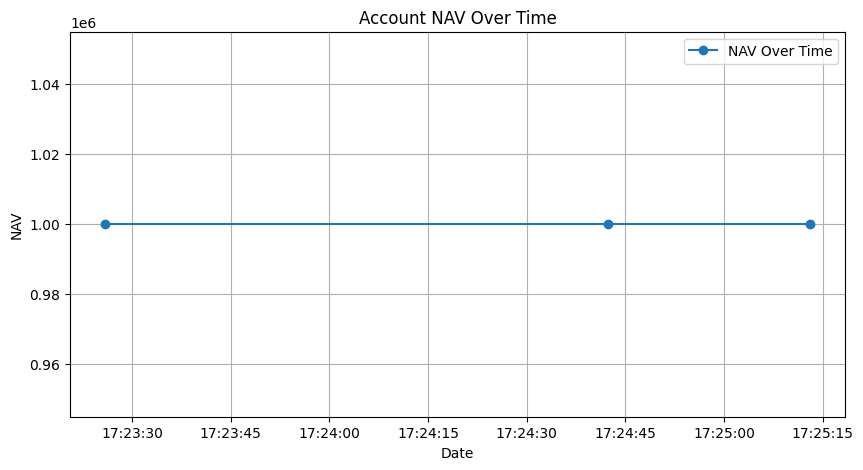

In [4]:
import datetime
import matplotlib.pyplot as plt
from mainsequence.client import AccountHistoricalHoldings,AccountRiskFactors


start_date = datetime.datetime(2025, 2, 25)
end_date = datetime.datetime(2025, 3, 1)

# Query with a date range filter
historical_holdings= AccountHistoricalHoldings.filter(
    holdings_date__gte=start_date,
    holdings_date__lte=end_date,
    related_account__id=accounts[0].id
)


# Extract NAV values and dates from historical holdings
nav_values = [holding.nav for holding in historical_holdings if holding.nav is not None]
dates = [holding.holdings_date for holding in historical_holdings if holding.nav is not None]

# Sort data by date
sorted_data = sorted(zip(dates, nav_values), key=lambda x: x[0])

if len(sorted_data) ==0:
    raise Exception("No data found")

dates, nav_values = zip(*sorted_data)

# Plot NAV over time
plt.figure(figsize=(10, 5))
plt.plot(dates, nav_values, marker='o', linestyle='-', label="NAV Over Time")
plt.xlabel("Date")
plt.ylabel("NAV")
plt.title("Account NAV Over Time")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


In [5]:
risk_factors=AccountRiskFactors.filter(related_holdings__id__in=[h.id for h in historical_holdings])


2025-04-18T18:52:53.800510Z [debug    ] took 0.7996 seconds. Requesting GET from http://127.0.0.1:8000/orm/api/assets/account_risk_factors/ application_name=ms-sdk data_source_id=1 job_run_id=None project_id=1 (at utils.py:95 in make_request())


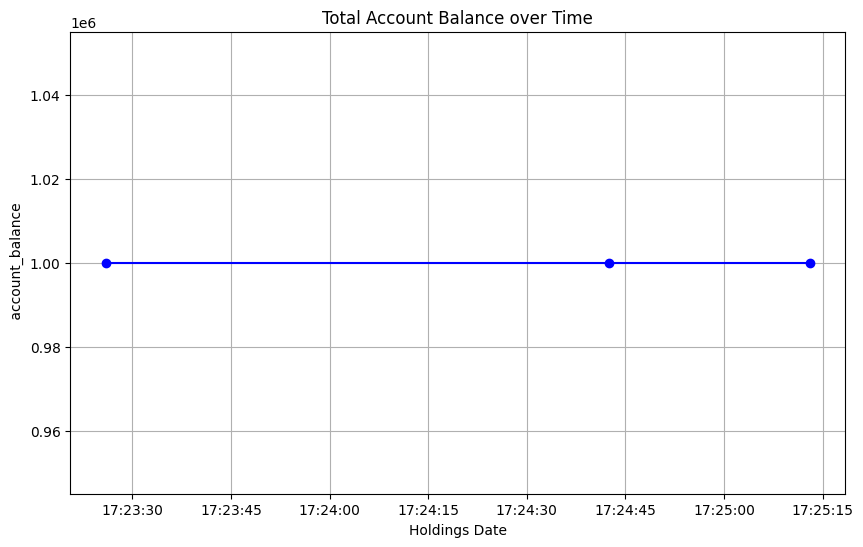

In [19]:

holdings_date_map = {h.id: h.holdings_date for h in historical_holdings}

# Prepare lists for plotting
dates = []
balances = []

# Loop over your risk factors data (a list of dictionaries)
for rf in risk_factors:
    holding_id = rf.related_holdings.id
    # Check if we have a corresponding holding date
    if holding_id in holdings_date_map.keys():
        dates.append(holdings_date_map[holding_id])
        balances.append(rf.account_balance)

# Optionally, sort the data by date if not already sorted
data = sorted(zip(dates, balances), key=lambda x: x[0])
sorted_dates, sorted_balances = zip(*data) if data else ([], [])

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(sorted_dates, sorted_balances, marker='o', linestyle='-', color='b')
plt.xlabel("Holdings Date")
plt.ylabel(" account_balance")
plt.title("Total Account Balance over Time")
plt.grid(True)
plt.show()
